In [2]:
# Imports
import sys

sys.path.insert(0, "../..")

from qiskit import QuantumCircuit, qasm2
from qiskit.quantum_info import Clifford, StabilizerState,state_fidelity
from qiskit.visualization import array_to_latex
from qiskit_aer import AerSimulator
import random
from visualisation import LiveVisualizer
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Clifford
from qiskit_aer import AerSimulator

from classical_shadow_n_clifford import ClassicalShadow_N_CLIFFORD
from shadow_protocol import ShadowProtocol

In [3]:
# Setup Experiment
class Id_Protocol(ShadowProtocol):

    def get_num_qubits(self) -> int:
        return 2
    
    def get_state_circuit(self) -> QuantumCircuit:
        circuit = QuantumCircuit(2)
        circuit.x(0)
        return circuit

    def run_circuit_and_get_measurement(self, circuit) -> list[int]:
        sim = AerSimulator()

        # Run with 997 shots
        job = sim.run(circuit, shots=997)
        result = job.result()

        counts = result.get_counts()
        max_hits= max(counts, key=counts.get)
        bit_list =  [int(bit) for bit in list(max_hits)]
        return bit_list[::-1] 
    
id_protocol = Id_Protocol()
# Create Classical Shadow Instance
shadow = ClassicalShadow_N_CLIFFORD(id_protocol)


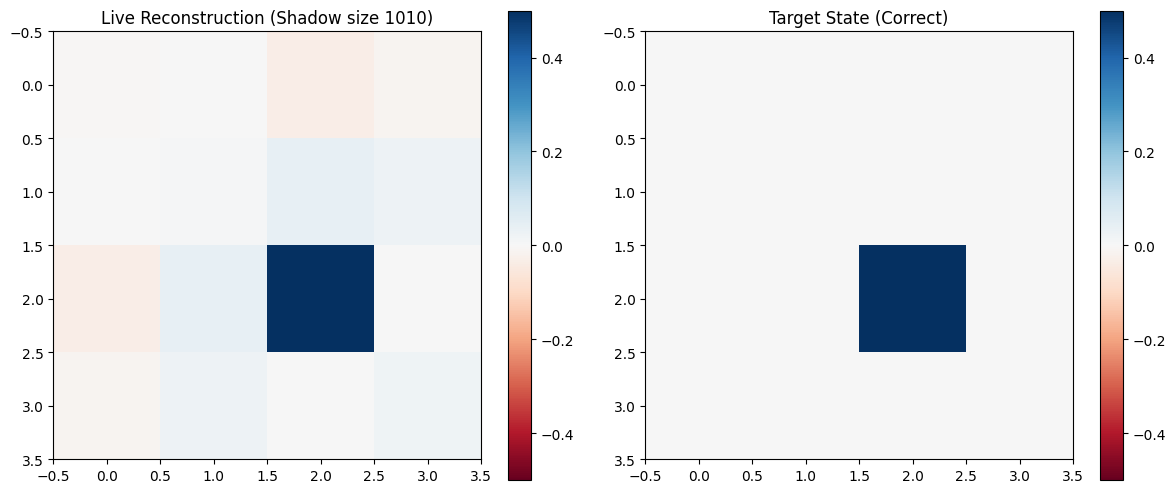

In [4]:
target_density_matrix = shadow.get_original_density_matrix()
vis = LiveVisualizer(target_density_matrix)


while shadow.get_shadow_size()<1010:
    shadow.add_snapshot()
    
    if shadow.get_shadow_size() > 1000:
        actual_density_matrix = shadow.get_density_matrix_from_stabilizers()

        vis.update(actual_density_matrix,shadow.get_shadow_size()) 

### Efficient Fidelity Estimation with Classical Shadows

When generating a classical shadow, we do not store the full snapshot matrix:
$$\hat{\rho} = \mathcal{M}^{-1}(U^\dagger |\hat{b}\rangle \langle \hat{b}| U)$$

Instead, we only store the efficient stabilizer representation of the state $|\phi\rangle = U^\dagger |\hat{b}\rangle$ according to the Gottesman-Knill theorem.

Explicitly applying $\mathcal{M}^{-1}$ would result in a matrix that is no longer a stabilizer state (due to the subtraction of the identity matrix), making it inefficient to store.

However, to calculate the fidelity with a target state $|\psi\rangle$, we can use the linearity of the trace to avoid constructing the full matrix. We estimate:

$$\text{tr}(|\psi\rangle \langle\psi| \hat{\rho})$$

Using the inverse channel formula $\mathcal{M}^{-1}(X) = (2^n + 1)X - \mathbb{I}$, we can rewrite the equation as:

$$
\begin{aligned}
\text{Est. Fidelity} &= \text{tr}\left( |\psi\rangle \langle\psi| \left[ (2^n + 1) |\phi\rangle \langle\phi| - \mathbb{I} \right] \right) \\
&= (2^n + 1) \text{tr}\left( |\psi\rangle \langle\psi| \phi\rangle \langle\phi| \right) - \text{tr}\left( |\psi\rangle \langle\psi| \mathbb{I} \right) \\
&= (2^n + 1) |\langle \psi | \phi \rangle|^2 - 1
\end{aligned}
$$

Calculating the overlap $|\langle \psi | \phi \rangle|^2$ between two pure states is computationally much more efficient than processing the full density matrix.

In [5]:
# Ort sate so the out come should be 0

ortognal_cir = QuantumCircuit(2)
ortognal_state = StabilizerState(ortognal_cir)

In [6]:
# Same sate so the out come should be 1

same_cir = QuantumCircuit(2)
same_cir.x(0)
same_state = StabilizerState(same_cir)

In [7]:
def getFidelity(stab_a: StabilizerState) -> float:
    stabilizer_list_list = shadow.stabilizer_list_list
    fidelities: list[float] = []

    # Optimization: Pre-calculate adjoint of A once to avoid recomputing in the loop
    cliff_a_inv = Clifford(stab_a).adjoint()

    for stab_list in stabilizer_list_list:
        assert len(stab_list) == 1
        stab_b: StabilizerState = stab_list[0]

        # Compute U_b * U_a^dagger (apply A inverse, then B)
        cliff_b = Clifford(stab_b)
        combined_cliff = cliff_b.compose(cliff_a_inv)

        # The overlap |<a|b>|^2 is the probability of measuring '0...0' on U_b * U_a^dagger |0>
        zero_state = StabilizerState(combined_cliff)
        probs = zero_state.probabilities_dict()
        
        fid = probs.get("0" * stab_a.num_qubits, 0.0)
        fidelities.append(fid)

    if not fidelities:
        raise ValueError("Fidelity list is empty. Cannot compute mean.")

    return sum(fidelities) / len(fidelities)

In [8]:
print(getFidelity(same_state))
print(getFidelity(ortognal_state))

TypeError: object of type 'StabilizerState' has no len()